# Recommender System Baseline tests for Goodbooks-10k dataset

## Importing data in Pandas Dataframe

In [1]:
%matplotlib inline

import pandas as pd

r = pd.read_csv( 'ratings.csv' )
tr = pd.read_csv( 'to_read.csv' )
b = pd.read_csv( 'books.csv' )

t = pd.read_csv( 'tags.csv' )
bt = pd.read_csv( 'book_tags.csv')


In [2]:
r.head()
num_users = r.user_id.max()
num_books = r.book_id.max()

Ratings are sorted chronologically, oldest first.

## Running Benchmark tests (kNN, SVD Factorization)

### Splitting the data into training and test sets

In [9]:
from surprise import NormalPredictor
from surprise.model_selection import train_test_split
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(r[['user_id', 'book_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.2,random_state=3)
fullset = data.build_full_trainset()

### Functions to calculate evaluation metrics

In [10]:
import numpy as np
import time
from surprise import accuracy
def rankOf(key,arr):                                                                                                           
    '''                                                                                                                        
    Returns rank of arr[key] in arr                                                                                            
    '''                                                                                                                        
    val = arr[key]                                                                                                             
    arrSort = sorted(arr)                                                                                                      
    v = len(arr)                                                                                                               
    for i in xrange(v-1,-1,-1):                                                                                                
        if arrSort[i]<=val:                                                                                                    
            return v-i                                                                                                         
    return 0  
def rankInTopK(algo,k=100):
    #Requires global variables trainset, testset, num_books
    i=0
    top_rated_rank=[]
    t=time.time()
    for entry in testset:
        if entry[2]==5.0: 
            book = fullset.to_raw_uid(entry[1])
            user = fullset.to_raw_uid(entry[0])
            i+=1
            negs=[book]
            while book in negs:
                negs=np.random.choice(num_books,k-1)
            negs=np.append(negs,book)
            pred_ratings=[]
            for item in negs:
                pred_ratings.append(algo.predict(user,item).est)
            top_rated_rank.append(rankOf(k-1,pred_ratings))
        if i==500: break #Comment this out for full test
    print ("Time taken in hours=%1.3f"%((time.time()-t)/3600))
    return top_rated_rank 
def rmseMeasure(algo):
    #Requires global variables testset
    predictions = algo.test(testset)
    return(accuracy.rmse(predictions))

### Fitting using Regularized-kNN method

In [ ]:
from surprise import KNNBaseline
algoStats={}
algoStats["knn"]={}
sim1 = {'name': 'pearson_baseline',
        'user_based': False,  # compute  similarities between items
        'shrinkage':0}
algo1 = KNNBaseline(k=40,min_k=1,sim_options=sim1)
algo1.fit(trainset)
algoStats["knn"]={'rmse':0.834,#rmseMeasure(algo1),
                  'topK_rank':rankInTopK(algo1,k=100)}

Estimating biases using als...


### Fitting using SVD Matrix Factorization method

In [70]:
from surprise import SVD
algoStats['svd']={}
algo2=SVD(n_factors=100,random_state=3)
algo2.fit(trainset)
algoStats["svd"]={'rmse':0.812,#rmseMeasure(algo1),
                'topK_rank':rankInTopK(algo1,k=100)}

KeyboardInterrupt: 

### Plotting the accuracy evaluation metric

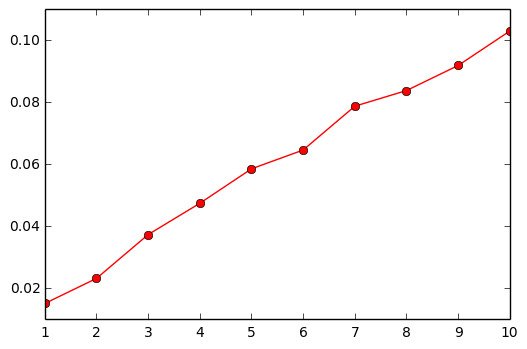

In [73]:
import matplotlib.pyplot as plt
hist1,bins=np.histogram(algoStats['knn']['topK_rank'],bins=50,range=(1,100),density=True)
hist1=np.cumsum(hist1)
# hist2,bins=np.histogram(algoStats['svd']['topK_rank'],bins=50,range=(1,100),density=True)
# hist2=np.cumsum(hist2)
plt.plot(range(1,11),hist1[0:10],'-or')
# plt.plot(range(1,11),hist2[0:10],'-+k')
plt.show()

# This is the End

### To read
These are the books users marked "to read".


In [ ]:
tr.head()

In [ ]:
len(tr)

Most books have been marked to read by somebody. Majority of the users have some books marked to read.

In [ ]:
len(tr.book_id.unique())

In [ ]:
len(tr.user_id.unique())

### Books

In [ ]:
b.head()

Books are sorted by their popularity, as measured by number of ratings (overall, not in this dataset).

In [ ]:
len(b)

### User and book IDs

In [3]:
r.user_id.max()

53424

In [4]:
r.book_id.max()

10000

The IDs are contiguous.

In [5]:
assert( len( r.user_id.unique()) == r.user_id.max())
assert( len( r.book_id.unique()) == r.book_id.max())

### Reviews per book

Most books have a few hundred reviews, but some have as few as eight.

In [ ]:
reviews_per_book = r.groupby( 'book_id' ).book_id.apply( lambda x: len( x ))
reviews_per_book.describe()

In [ ]:
reviews_per_book.sort_values().head( 10 )

### Reviews per user

All users have at least 19 reviews.

In [ ]:
reviews_per_user = r.groupby( 'user_id' ).user_id.apply( lambda x: len( x ))
reviews_per_user.describe()

In [ ]:
reviews_per_user.sort_values().head( 10 )

### Tags

In [ ]:
t.head()

In [ ]:
len(t)

In [ ]:
bt.head()

Tag applications are sorted by goodreads_book_id ASC and by count DESC.

In [ ]:
len(bt)

Let us merge tag names into tag applications.

In [ ]:
bt = bt.merge( t, on = 'tag_id' )

Why don't we merge book titles for good measure.

In [ ]:
bt = bt.merge( b[[ 'goodreads_book_id', 'title']], on = 'goodreads_book_id' )

It appears that there are some negative tag counts. Let's fix this.

In [ ]:
bt['count'].describe()

In [ ]:
bt.loc[ bt['count'] < 0, 'count'] = 0

Sample some popular book tags.

In [ ]:
bt.sample( 10, weights = 'count')

These are the most popular tags:

In [ ]:
tag_counts = bt.groupby( 'tag_name' ).tag_name.count().sort_values( ascending = False )
tag_counts.head( 20 )

# Cleaning up Data

## Removing rows that contain duplicate user_id, book_id

In [6]:
print(len(r))
r_duplicates_removed = r.drop_duplicates(['user_id','book_id'])
print(len(r_duplicates_removed))
r=r_duplicates_removed

5976479
5976479


In [ ]:
r.head()

## Removing users with no. of ratings below a threshold (20 here)

In [7]:
ruser = r.set_index('user_id',drop=False)
ruser['books_rated']=r['user_id'].value_counts()
print(len(ruser))
ruser.sort_values(by='books_rated').head()

5976479


,user_id,book_id,rating,books_rated
user_id,,,,
34590,34590,9967,5,19
34590,34590,852,5,19
34590,34590,35,5,19
34590,34590,8634,4,19
34590,34590,1180,5,19


In [8]:
ruser=ruser.drop(ruser[ruser.books_rated<20].index)
print(ruser.sort_values(by='books_rated').head())
r=ruser.reset_index(drop=True)
ruser=r.drop(ruser[ruser.rating<3].index)
ruser.head()

         user_id  book_id  rating  books_rated
user_id                                       
43675      43675       27       5           20
43675      43675     8634       5           20
43675      43675      796       3           20
43675      43675       24       5           20
43675      43675      399       4           20


,user_id,book_id,rating,books_rated
0,1,258,5,117
15,4,18,5,134
17,4,21,5,134
29,4,58,4,134
83,4,50,4,134


In [9]:
userbooks = r[['user_id','books_rated']].copy()
userbooks.drop_duplicates('user_id',inplace=True)
#userbooks.set_index('user_id',inplace=True,drop=False)
userbooks=userbooks.sort_values(by='books_rated',ascending=False)
userbooks.head()


,user_id,books_rated
2332463,30944,200
786481,12874,200
5884967,52036,199
1282352,12381,199
2073923,28158,199


## Extracting only English books 

In [10]:
b['is_english']=b.language_code=='eng'
b_lang=b[['book_id','is_english']]
rm=r.merge(b_lang,how='inner',on = 'book_id')
rm=rm.drop(rm[rm.is_english==False].index)
rm.head()

,user_id,book_id,rating,books_rated,is_english
0,1,258,5,117,True
1,11,258,3,120,True
2,143,258,4,159,True
3,242,258,5,123,True
4,325,258,4,132,True


## Writing Training, Test and Negative files

In [ ]:
import random
import time
import numpy as np
bookMax = int(rm.max()['book_id'])
userMax = int(rm.max()['user_id'])
userMax=10
rind = rm.drop(rm[rm.rating<3].index)
#Dropping users giving less than 3 ratings(seen as negative review)
rind = rind.set_index('user_id',drop=False)
rind = rind.drop('is_english',axis=1)
rind = rind.drop('books_rated',axis=1
univSet = set(range(1,bookMax+1))
testset=pd.DataFrame()
#a.append(rind.loc[10].sample(1))
with open('./gb-10k.test.negative','a') as inp:
    for u in xrange(1,userMax+1):
        x=rind.loc[u].sample(1)
        s='('+str(x.loc[u]['user_id'])+','+str(x.loc[u]['book_id'])+')  '
        neg=random.sample(list(univSet-set(rind.loc[u]['book_id'])),99)
        for it in neg:
            s+=str(it)
            s+='\t'
        s=s.strip('\t')
        s+='\n'
        inp.write(s)
        testset=testset.append(x)
#print neg99
trainset = rind[~rind.isin(testset).all(1)]
# print testset
# trainset.head()
testset.to_csv('./gb-10k.test.rating',sep='\t',index=False,header=False)
trainset.sort_values(by='user_id',inplace=True)
trainset.to_csv('./gb-10k.train.rating',sep='\t',index=False,header=False)

# Test Samples

In [ ]:
import numpy as np
testset.loc[4]['user_id']
a=str((5,3))+'\n'+'hello'
a
print a
#a.strip('\t')
131 in trainset.loc[1]['book_id'].tolist()

#testset.drop('is_english',axis=1)
trainset.sort_values(by='user_id').head()

## Make Ratings Matrix

In [ ]:
help(rind.sort)

# Collaborative Filtering k-Nearest-Neighbours

In [ ]:
def common_books_users(ratemat,tgtId):
    simUsers,n = [],len(ratemat)
    userVec = ratemat[tgtId]
    for i in xrange(1,n):
        if i == tgtId:
            continue
        if (ratemat[i] & userVec).any():
            simUsers.append(i)
    return simUsers

In [ ]:
def top_k_similar(simUsers,tgtId,ratemat,k=20):
    #simvec = ratemat[np.ix_(simUsers)]
    userVec = ratemat[tgtId]
    userWt= []
    for id in simUsers:
        userWt.append((id,np.corrcoef(ratemat[id],userVec)[0,1]))
    userWt = sorted(UserWt,key=lambda x:x[1])
    return userWt[:k]

In [ ]:
def recommend_books(userWt,tgtId,ratemat):
    U,B = ratemat.shape
    nbrRate = np.zeros(B)
    for uid,wt in userWt:
        nprRate+=wt*ratemat[uid,:]
    recRate = np.where(ratemat[tgtId]>0.0,0.0,nbrRate)
    recBooks = np.argsort(recRate)[-10:]
    

In [ ]:
a=[(1,3),(2,5),(9,0)]
for k,v in a:
    print k,v
    

In [46]:
import numpy as np
a=np.array([1.2,3.6,0.0,0.0])
b = np.array([3.4,6.2,1.3,2.6])
d=np.where(a>0.0,0.0,b)
print d
np.argsort(d)[-2:]

[0.  0.  1.3 2.6]


array([2, 3])

In [41]:
help(np.where)

Help on built-in function where in module numpy.core.multiarray:

where(...)
    where(condition, [x, y])
    
    Return elements, either from `x` or `y`, depending on `condition`.
    
    If only `condition` is given, return ``condition.nonzero()``.
    
    Parameters
    ----------
    condition : array_like, bool
        When True, yield `x`, otherwise yield `y`.
    x, y : array_like, optional
        Values from which to choose. `x`, `y` and `condition` need to be
        broadcastable to some shape.
    
    Returns
    -------
    out : ndarray or tuple of ndarrays
        If both `x` and `y` are specified, the output array contains
        elements of `x` where `condition` is True, and elements from
        `y` elsewhere.
    
        If only `condition` is given, return the tuple
        ``condition.nonzero()``, the indices where `condition` is True.
    
    See Also
    --------
    nonzero, choose
    
    Notes
    -----
    If `x` and `y` are given and input arrays are